In [1]:
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [264]:
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, label
from skimage.measure import find_contours
from skimage.util import img_as_bool
from skimage.feature import local_binary_pattern


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Callable
from datetime import datetime

## Reference data

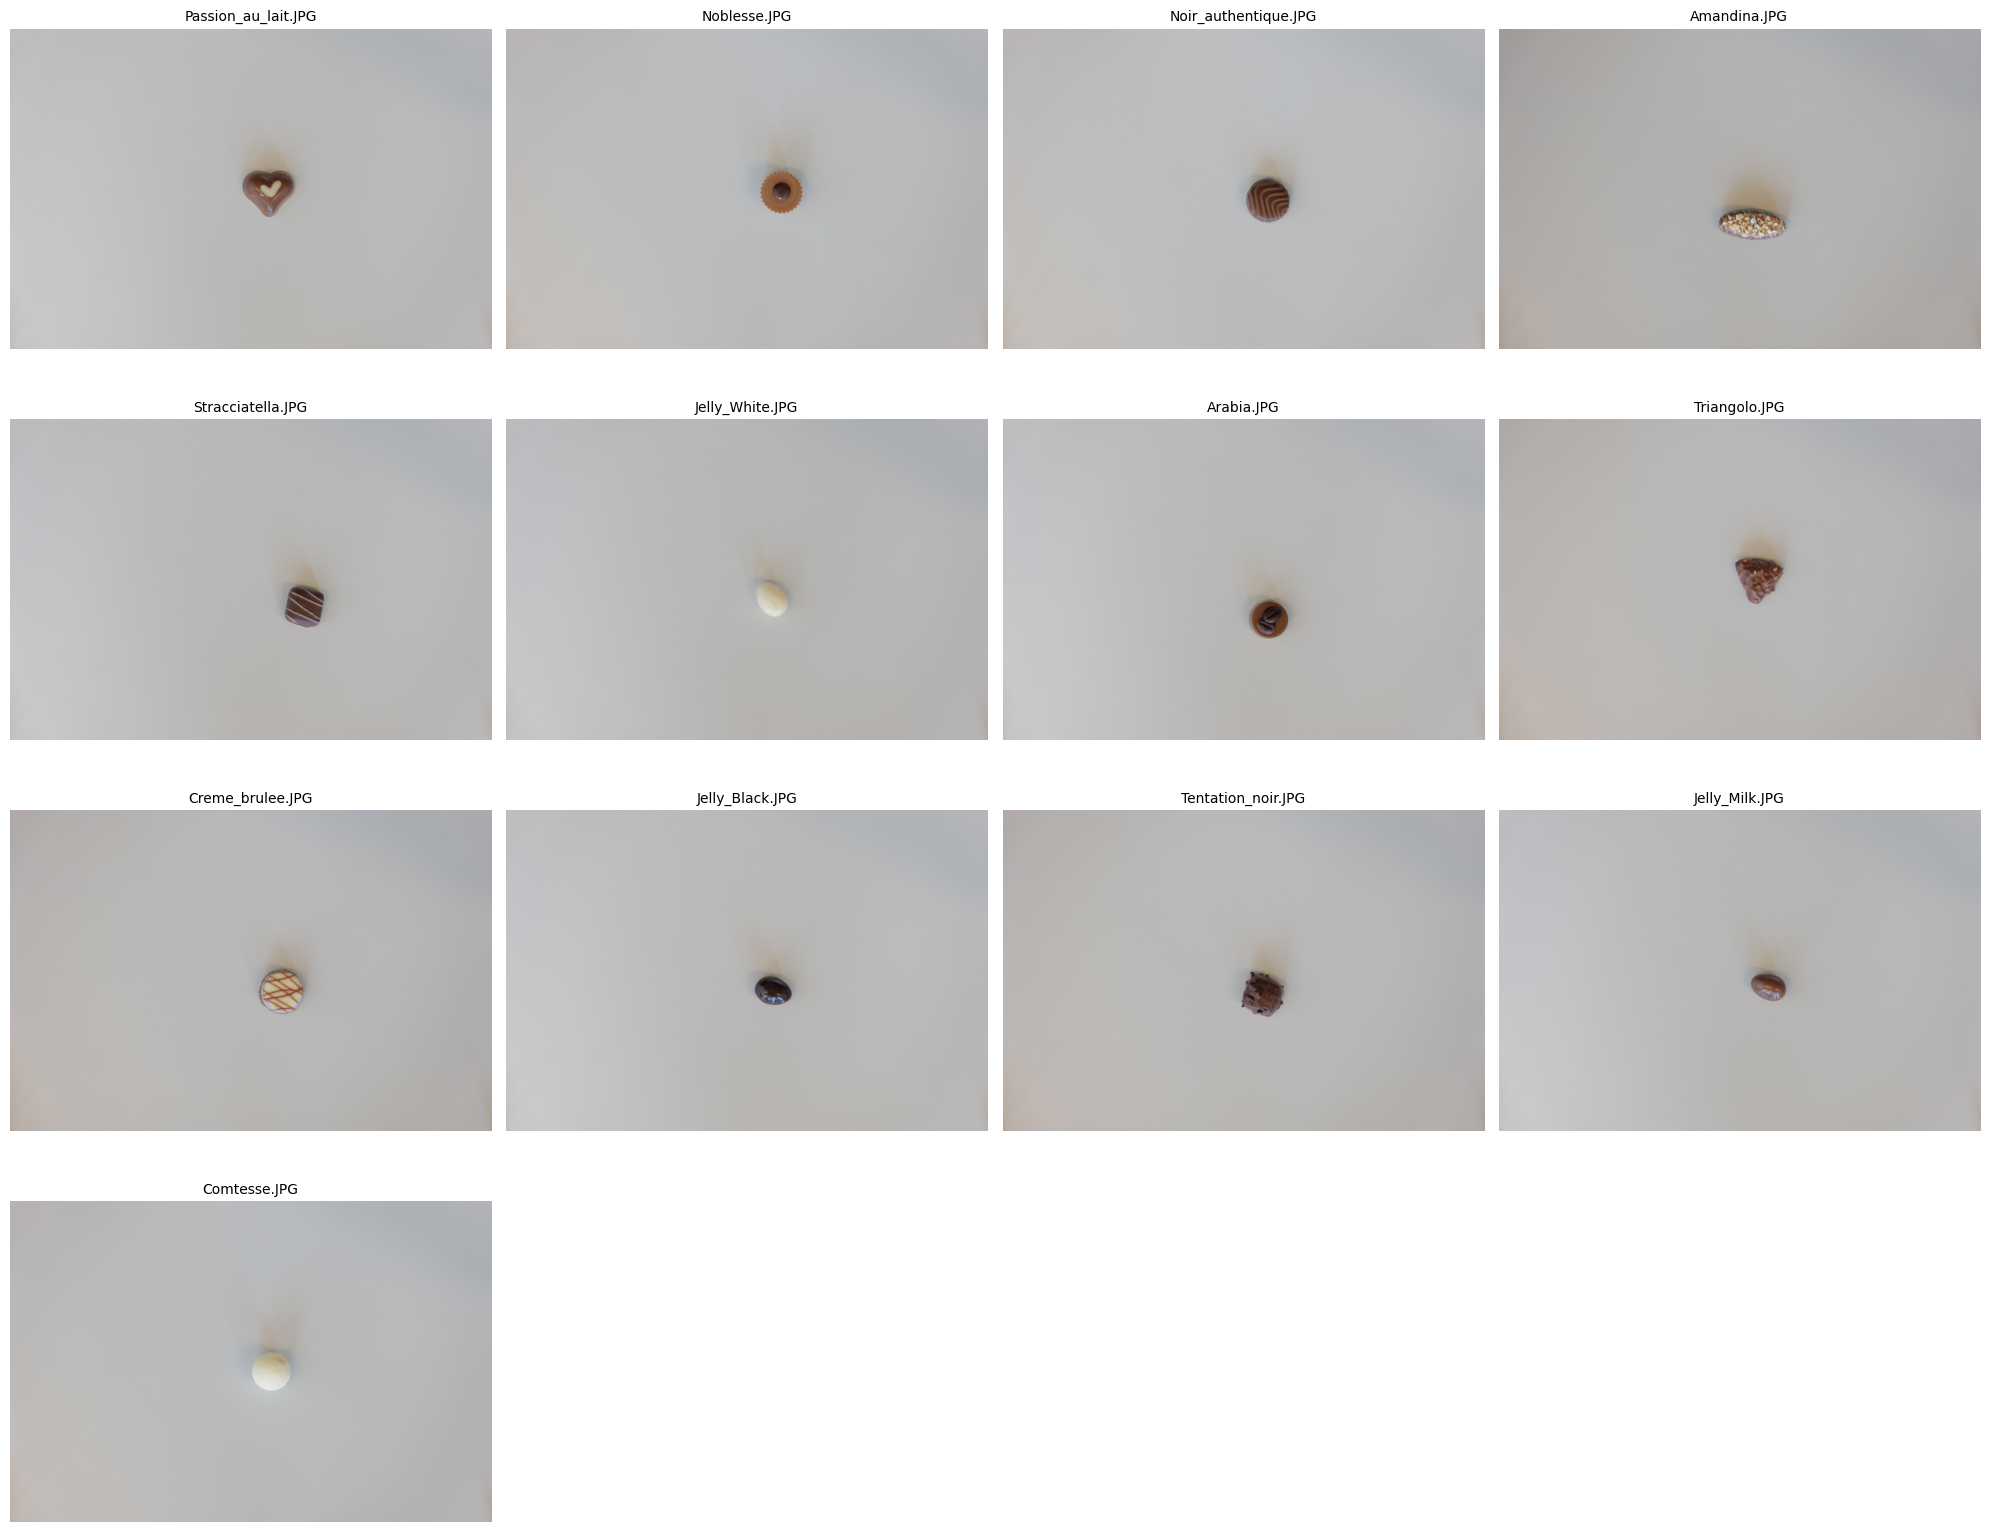

In [3]:
ref_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/references/'
image_names = os.listdir(ref_dir)

cols = 4
rows = (len(image_names) + cols - 1) // cols 

rgb_images = []
grayscale_images = []

plt.figure(figsize=(20, 4 * rows))
for i, im in enumerate(image_names): 
    img = cv2.imread(os.path.join(ref_dir, im))
    img = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    rgb_images.append(img_rgb)
    grayscale_images.append(gray)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(im, fontsize=10)

plt.tight_layout()

Compute contours and image moments.

In [4]:
def linear_interpolation(contours: np.ndarray, n_samples: int = 11):
    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))
    
    for i in range(N):
        x = contours[i][:, 0]
        y = contours[i][:, 1]

        t = np.zeros(len(x))
        t[1:] = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))

        t_prime = np.linspace(0, t[-1], n_samples)

        contours_inter[i, :, 0] = np.interp(t_prime, t, x)
        contours_inter[i, :, 1] = np.interp(t_prime, t, y)
    
    return contours_inter


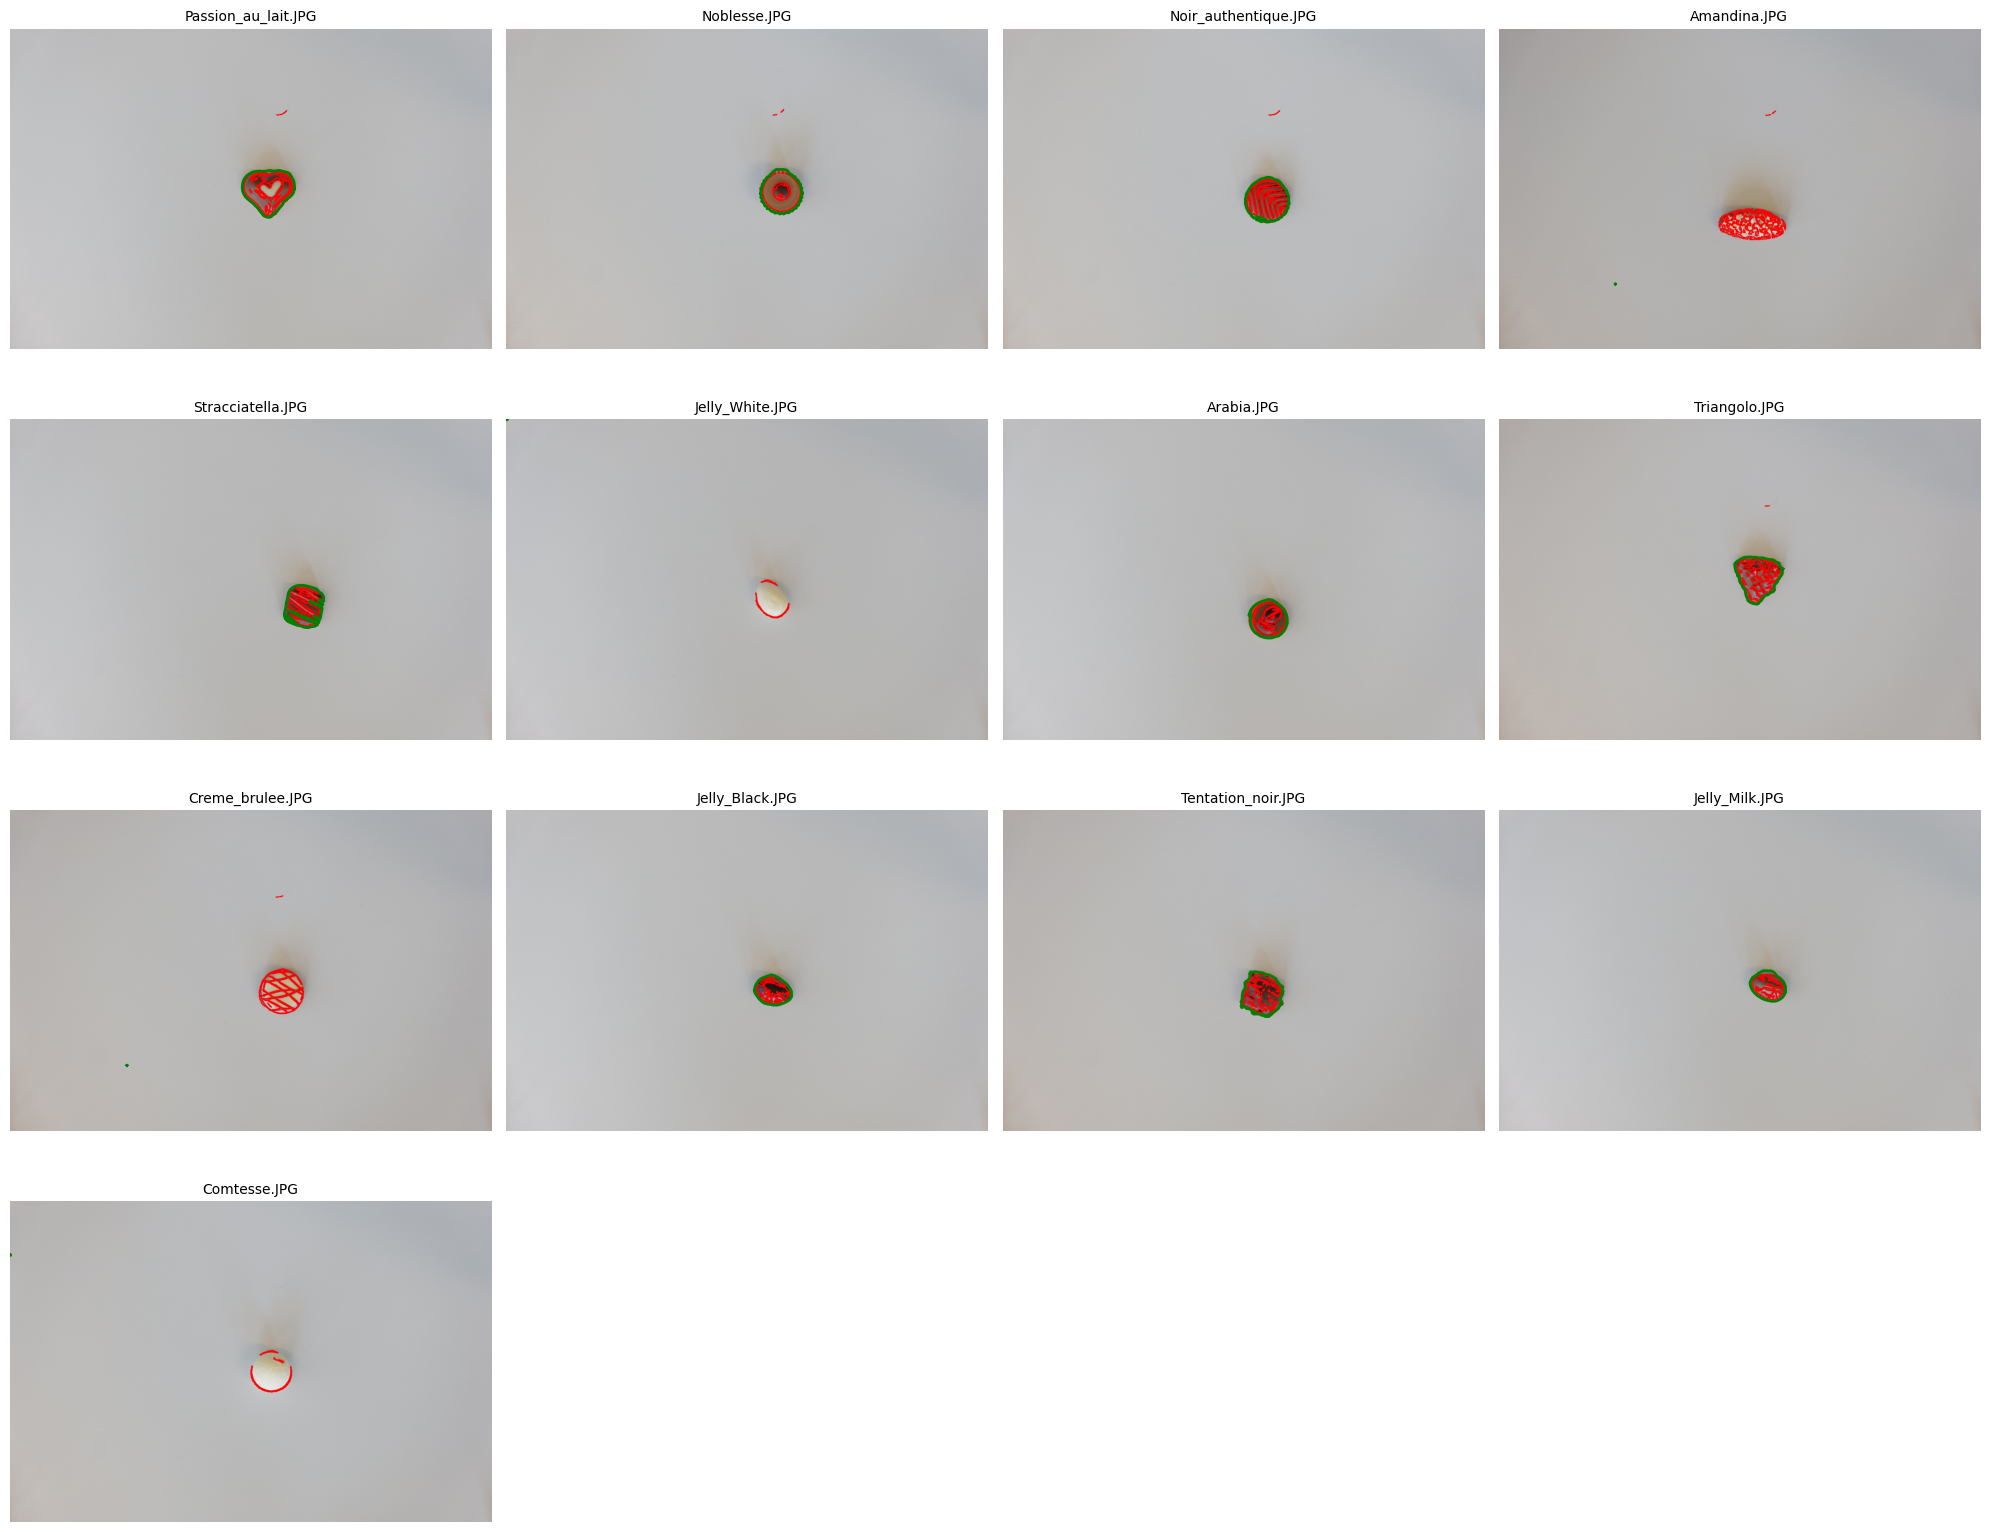

In [ ]:
hu_moments_all = []
contours_all = []
thresholded_all = []
edges_all = []
histograms_all = []

plt.figure(figsize=(20, 4 * rows))

for i, gray in enumerate(grayscale_images):

    ## Thresholding
    _, thresh0 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresholded_all.append(thresh0)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, blockSize=27, C=5)
    edges_all.append(thresh)

    ## Morphological operations
    binary = img_as_bool(thresh) 
    cleaned = remove_small_objects(binary, min_size=20)
    cleaned = remove_small_holes(cleaned, area_threshold=1000) 
    processed = (cleaned * 255).astype(np.uint8)

    ## Find contours and draw them
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # or use cv2.RETR_LIST or cv2.RETR_EXTERNAL
    contours_all.append(contours)

    contour = find_contours(thresh0.T)[0]
    interpolated = linear_interpolation([contour], n_samples=80)[0]

    ## Moments 
    img_copy = rgb_images[i].copy()
    img_hu_moments = []
    for cnt in contours:
        hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()
        img_hu_moments.append(hu_moments)

        cv2.drawContours(img_copy, [cnt], -1, (255, 0, 0), 2)

        x, y, w, h = cv2.boundingRect(cnt)
        roi = rgb_images[i][y:y+h, x:x+w] 

        hist = cv2.calcHist([roi], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        histograms_all.append(hist)

    hu_moments_all.append(img_hu_moments)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_copy)
    plt.plot(interpolated[:, 0], interpolated[:, 1], 'g-', linewidth=2)
    plt.axis('off')
    plt.title(image_names[i], fontsize=10)

plt.tight_layout()

Distance map

In [6]:
def compute_distance_map(pattern: np.ndarray):
    distance_map = np.zeros_like(pattern)
    
    contours = find_contours(pattern)[0]
    contours = linear_interpolation([contours], n_samples=80)[0]
    
    distance_map = np.zeros(pattern.shape)

    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            distance_map[i, j] = np.min(np.linalg.norm(contours - np.array([i, j]), axis=1))
    
    return distance_map

In [29]:
distance_maps_all = []

for i, gray in enumerate(grayscale_images):
    thresh = thresholded_all[i]
    contour = find_contours(thresh)[0]
    interpolated = linear_interpolation([contour], n_samples=80)[0]
    distance_map = compute_distance_map(thresh)
    distance_maps_all.append(distance_map)

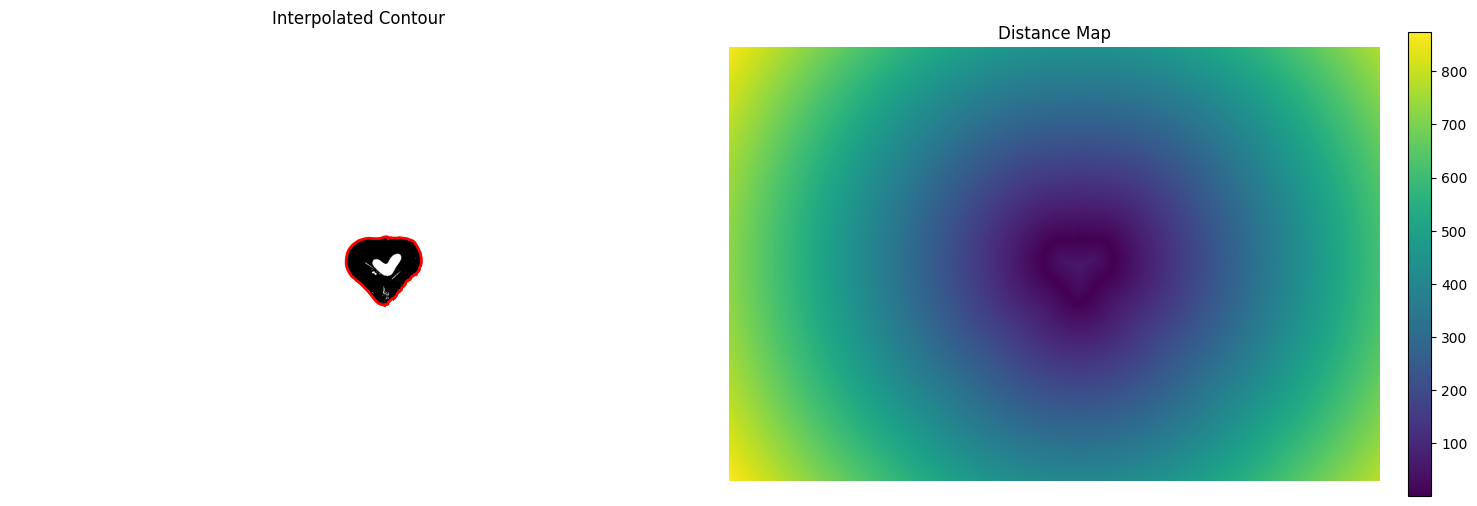

In [ ]:
idx = 0
reference = grayscale_images[idx]
thresh = thresholded_all[idx]
contour = find_contours(thresh, 0)[0]
distance_map = compute_distance_map(thresh)
interpolated = linear_interpolation([contour], n_samples=80)[0]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(thresh, cmap='gray')
axes[0].plot(interpolated[:, 1], interpolated[:, 0], 'r-', linewidth=2)
axes[0].set_title("Interpolated Contour")
axes[0].axis('off')
im = axes[1].imshow(distance_map, cmap='viridis')
axes[1].set_title("Distance Map")
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()

Ideas/notes:
- For chocolates with particular patterns, we can use the pattern as a reference. This can be done using contours.
- For chocolates with no particular patterns, we can use the color of the chocolate as a reference.

For example, jelly blacks, jelly whites and jelly milks have the same shape but not the same colors.
And noir authentique and creme brulee have roughly same shapes but not the same patterns or colors.

Since for patterns contours work well, we can use distance maps or fourier descriptors.

Other ideas:
- Use contours to find chocolates and objects
- Bring each detected object to its own image (seperate it)
- Then compare to each reference image (classification)
    -> can do multiple ways at same time (minimize color difference and shape difference for example)
    -> which is why for now I need to first get a reference set, with different features to be able to compare to train set
- Can modify contour per chcolate? But needs to work in real cases..

## Testing on a realistic image

(np.float64(-0.5), np.float64(1499.5), np.float64(999.5), np.float64(-0.5))

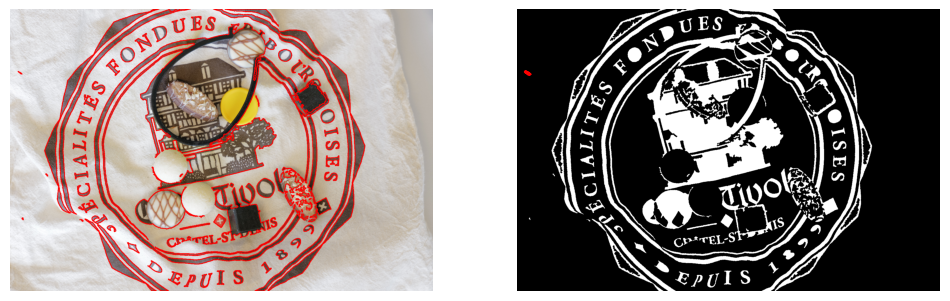

In [230]:
train_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/train/'
train_image_names = os.listdir(train_dir)
train_image = cv2.imread(os.path.join(train_dir, train_image_names[0]))
train_image = cv2.resize(train_image, (train_image.shape[1] // 4, train_image.shape[0] // 4))
train_image_rgb = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)

train_thresh = cv2.adaptiveThreshold(train_image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, blockSize=27, C=11)
#_, train_thresh = cv2.threshold(train_image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

train_cleaned = img_as_bool(train_thresh)
train_cleaned = remove_small_objects(train_cleaned, min_size=20)
train_cleaned = closing(train_cleaned, disk(2))
train_cleaned = remove_small_holes(train_cleaned, area_threshold=1000)
train_cleaned = (train_cleaned * 255).astype(np.uint8)

train_contours, _ = cv2.findContours(train_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
interpolated_train = linear_interpolation([find_contours(train_cleaned.T)[0]], n_samples=80)[0]

cv2.drawContours(train_image_rgb, train_contours, -1, (255, 0, 0), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(train_image_rgb)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(train_cleaned, cmap='gray')
plt.plot(interpolated_train[:, 0], interpolated_train[:, 1], 'r-', linewidth=2)
plt.axis('off')

In [231]:
def best_match(contour, reference_contours_all, threshold=0.2):
    best_score = float('inf')
    best_index = -1

    for idx, ref_contours in enumerate(reference_contours_all):
        for ref_cnt in ref_contours:
            score = cv2.matchShapes(contour, ref_cnt, cv2.CONTOURS_MATCH_I1, 0.0)
            if score < best_score:
                best_score = score
                best_index = idx

    if best_score < threshold:
        return best_index, best_score
    else:
        return None, best_score 
    
def hu_distance(hu1, hu2):
    hu1_log = -np.sign(hu1) * np.log10(np.abs(hu1) + 1e-10)
    hu2_log = -np.sign(hu2) * np.log10(np.abs(hu2) + 1e-10)
    return np.sum(np.abs(hu1_log - hu2_log))

In [240]:
matched_contours = []
matched_indices = []

for cnt in train_contours:
    if cv2.contourArea(cnt) < 5000:  # filter small noise
        continue
    match_idx, score = best_match(cnt, contours_all)
    if match_idx is not None:
        matched_contours.append(cnt)
        matched_indices.append(match_idx)


In [238]:
matched_contours = []
matched_indices = []
hu_threshold = 0.9

for cnt in train_contours:
    if cv2.contourArea(cnt) < 50:
        continue

    hu_test = cv2.HuMoments(cv2.moments(cnt)).flatten()
    best_score = float('inf')
    best_index = (-1, -1)

    for i, ref_image_hus in enumerate(hu_moments_all):
        for j, hu_ref in enumerate(ref_image_hus):
            dist = hu_distance(hu_test, hu_ref)
            if dist < best_score:
                best_score = dist
                best_index = (i, j)

    if best_score < hu_threshold:
        matched_contours.append(cnt)
        matched_indices.append(best_index)


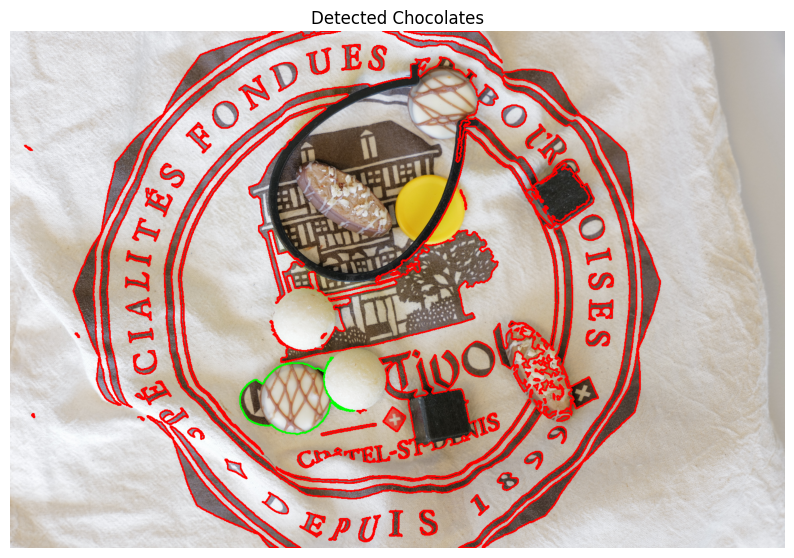

In [241]:
output_image = train_image_rgb.copy()
for i, cnt in enumerate(matched_contours):
    cv2.drawContours(output_image, [cnt], -1, (0, 255, 0), 2)
    x, y, w, h = cv2.boundingRect(cnt)

plt.figure(figsize=(10, 8))
plt.imshow(output_image)
plt.axis('off')
plt.title("Detected Chocolates")
plt.show()


Try region growing for object detection instead.

In [242]:
train_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/train/'
train_image_names = os.listdir(train_dir)
train_image = cv2.imread(os.path.join(train_dir, train_image_names[0]))
train_image = cv2.resize(train_image, (train_image.shape[1] // 4, train_image.shape[0] // 4))
train_image_rgb = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)

In [ ]:
def region_growing(seeds: list[tuple], img: np.ndarray, n_max: int = 10, threshold: int = 20):

    M, N, _ = img.shape
    rg = np.zeros((M, N)).astype(bool)
    
    img_gray = img
    threshold = threshold

    if seeds is None:
        seeds = np.array([(i, j) for i in range(0, M, 50) for j in range(0, N, 50)])
    else:
        seeds = np.array(seeds)

    rg[seeds[:,0], seeds[:,1]] = True 

    for i in range(int(n_max)):
        
        mean_intensity = img_gray[rg].mean(axis=0) if rg.any() else 0
        rg_dilated = binary_dilation(rg) 
        new_pixels = rg_dilated & ~rg
        mask = np.linalg.norm(img_gray[new_pixels] - mean_intensity, axis=1) <= threshold
       
        if not np.any(mask): 
            break

        rg[new_pixels] = mask 
                    
    return rg

def plot_region_growing(seeds: list[tuple], img: np.ndarray, func: Callable, iters: list[int], threshold: int = 20):

    n = len(iters) + 1
    n_rows = np.ceil(n // 2).astype(int)
    _, axes = plt.subplots(n_rows, 2, figsize=(16, 6*n_rows))
    axes = axes.ravel()
    [a.axis('off') for a in axes]   

    axes[0].imshow(img)
    axes[0].set_title("Input image")

    for i, it in enumerate(iters):
        t1 = datetime.now()
        img_rg = func(seeds=seeds, img=img, n_max=iters[i], threshold=threshold)
        t2 = datetime.now()
        seconds = (t2 - t1).total_seconds()
        axes[i+1].imshow(img_rg)
        axes[i+1].set_title("RG {} iter in {:.2f} seconds".format(iters[i], seconds))
                            
    plt.tight_layout()
    return img_rg

In [ ]:
def region_growing_texture(seeds: list[tuple], img: np.ndarray, n_max: int = 10, threshold: float = 5.0, patch_size=5):
    M, N = img.shape
    rg = np.zeros((M, N), dtype=bool)

    if seeds is None:
        seeds = np.array([(i, j) for i in range(0, M, 50) for j in range(0, N, 50)])
    else:
        seeds = np.array(seeds)

    rg[seeds[:, 0], seeds[:, 1]] = True

    for i in range(n_max):
        region_values = img[rg]
        if region_values.size == 0:
            break
        region_std = np.std(region_values)

        rg_dilated = binary_dilation(rg)
        new_pixels = rg_dilated & ~rg
        new_coords = np.argwhere(new_pixels)

        accepted = []
        for y, x in new_coords:
            y1, y2 = max(0, y - patch_size), min(M, y + patch_size + 1)
            x1, x2 = max(0, x - patch_size), min(N, x + patch_size + 1)
            patch = img[y1:y2, x1:x2]
            patch_std = np.std(patch)

            if abs(patch_std - region_std) < threshold:
                accepted.append((y, x))

        if not accepted:
            break

        for y, x in accepted:
            rg[y, x] = True

    return rg


array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

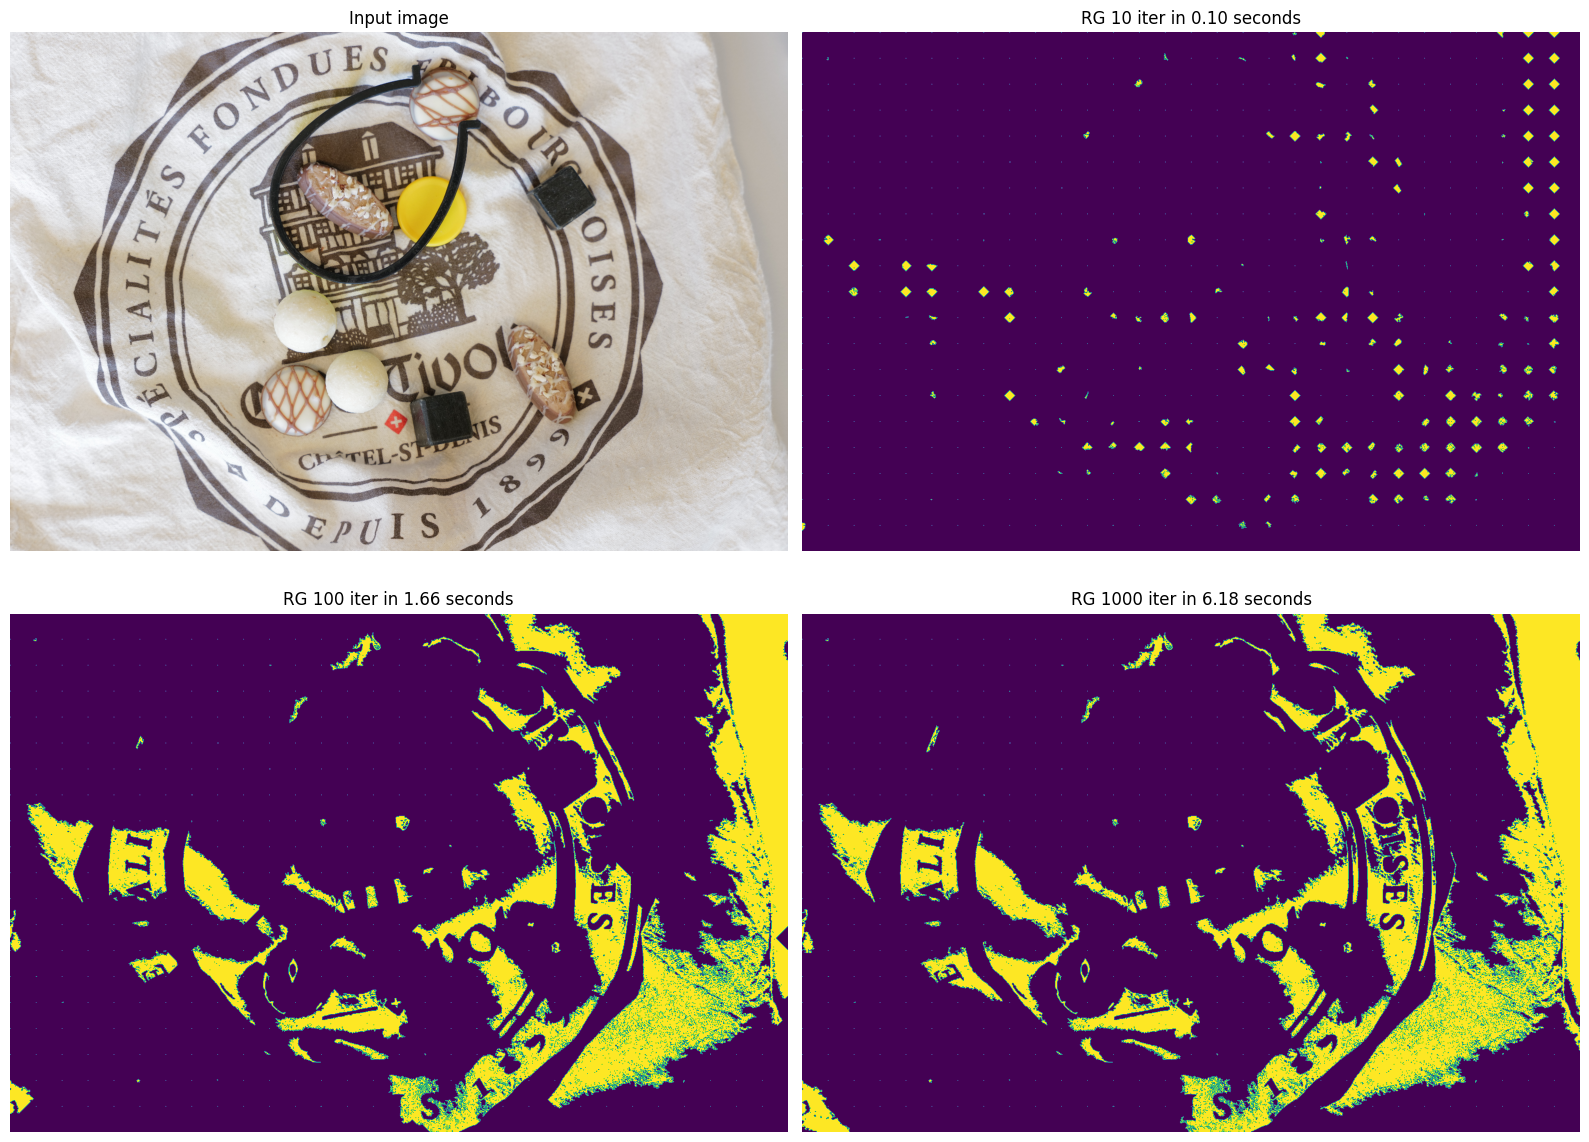

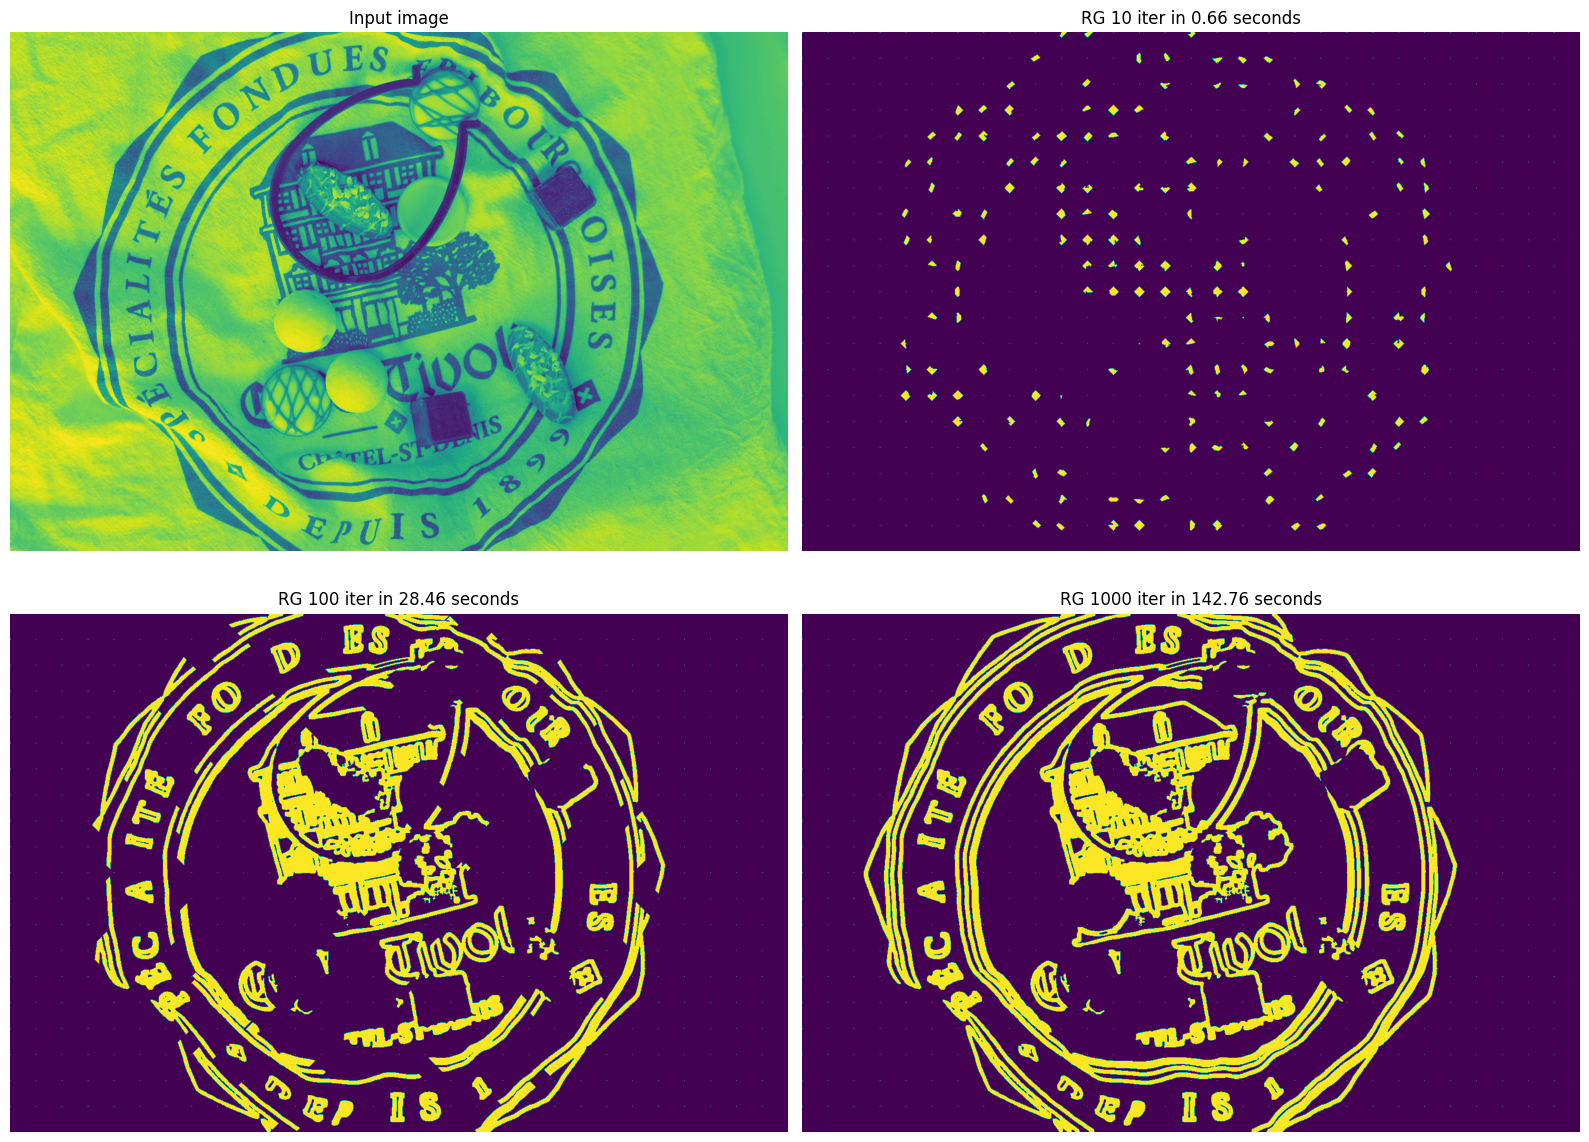

In [ ]:
plot_region_growing(seeds=None, img=train_image_rgb, func=region_growing, iters=[10, 100, 1000], threshold=25)
plot_region_growing(seeds=None, img=train_image_gray, func=region_growing_texture, iters=[10, 100, 1000], threshold=35)

In [ ]:
def classify_regions_by_hu(label_map, image_gray, reference_hu_moments, hu_threshold=0.1):
    matched_regions = []
    output_image = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)

    for region_label in np.unique(label_map):
        if region_label == 0:
            continue

        mask = (label_map == region_label).astype(np.uint8) * 255

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        cnt = max(contours, key=cv2.contourArea)
        if cv2.contourArea(cnt) < 100:
            continue

        hu = cv2.HuMoments(cv2.moments(cnt)).flatten()

        best_score = float('inf')
        for ref_hus in reference_hu_moments:
            for ref_hu in ref_hus:
                score = np.sum(np.abs(np.log(np.abs(hu) + 1e-6) - np.log(np.abs(ref_hu) + 1e-6)))
                best_score = min(best_score, score)

        if best_score < hu_threshold:
            matched_regions.append((cnt, best_score))
            cv2.drawContours(output_image, [cnt], -1, (0, 255, 0), 2)

    return output_image, matched_regions


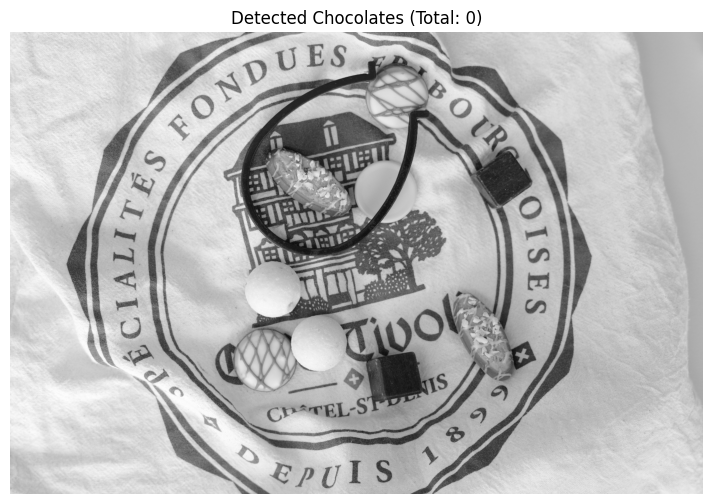

In [269]:
label_map = region_growing_texture(seeds=None, img=train_image_gray, n_max=1000, threshold=35)

classified_img, matched = classify_regions_by_hu(label_map, train_image_gray, hu_moments_all, hu_threshold=0.25)

plt.figure(figsize=(12, 6))
plt.imshow(classified_img)
plt.title(f"Detected Chocolates (Total: {len(matched)})")
plt.axis('off')
plt.show()